# Keras (Tensorflow Backend) を利用してMNISTの分類を行う

## 概要

このノートブックでは、Amazon SageMaker上でKerasを実行し、MNISTの手書き数字の分類を学習します。Kerasを動作させるpythonのファイルとして、以下の2種類を`./src`に保存しています。

- [keras_mlp_mnist.py](./src/keras_mlp_mnist.py)  
Kerasで簡単なMLPを構築したものです。
- [keras_cnn_mnist.py](./src/keras_cnn_mnist.py)  
KerasのMNIST用の[CNN](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py)をベースに作成しています。


## データセットのS3へのアップロード

- keras.datasetsを利用してmnistのデータをダウンロードしてnpz形式で保存します。
- 保存したnpz形式のファイルを、SageMaker Python SDKを利用してS3にアップロードします。

In [2]:
import os
import keras
import numpy as np
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

os.makedirs("./data", exist_ok = True)

np.savez('./data/train', image=x_train, label=y_train)
np.savez('./data/test', image=x_test, label=y_test)

import sagemaker
sagemaker_session = sagemaker.Session()
bucket_name = sagemaker_session.default_bucket()
input_data = sagemaker_session.upload_data(path='./data', bucket=bucket_name, key_prefix='dataset/mnist')
print('Training data is uploaded to: {}'.format(input_data))

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-666254511816


Training data is uploaded to: s3://sagemaker-us-east-1-666254511816/dataset/mnist


## コードの変更箇所

kerasのMNIST用の[CNN](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py)とSageMaker用のコード[keras_cnn_mnist.py](./src/keras_cnn_mnist.py)の違いを紹介します。SageMaker用のコードでは以下の4点が異なります。


**1. 以下のmain guardの中に、学習してモデルを保存するまでのコードを書くようにします。**

```python
    if __name__ == '__main__':
```

**2. Main guardの最初には、APIから渡される引数やS3上の学習データの位置、モデルの保存場所を受け取るコードを書きます。**

```python
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--batch-size', type=int, default=100)
    parser.add_argument('--n-class', type=int, default=10)
    ...
    
    args, _ = parser.parse_known_args()
```
**3. 学習完了後、KerasのモデルでなくTensorflow Servingでデプロイ可能なモデルとして保存します。**

Tensorflow Serving で利用できるようにモデルを保存します。

```python
    sess = K.get_session()
    tf.saved_model.simple_save(
        sess,
        os.path.join(args.model_dir, 'model/1'),
        inputs={'inputs': model.input},
        outputs={t.name: t for t in model.outputs})
```


## SageMakerでの学習

MXNetをバックエンドとして学習するため、MXNetのEstimatorを呼び出します。利用するpythonのコードは、`keras_mlp_mnist.py`と`keras_cnn_mnist.py`のどちらでも可能です。MLPのほうが短時間で学習が終わります。

In [ ]:
from sagemaker.tensorflow import TensorFlow
from sagemaker import get_execution_role

role = get_execution_role()
mnist_estimator = TensorFlow(entry_point = "./src/keras_mlp_mnist.py",
          role=role,
          train_instance_count=1,
          train_instance_type="ml.m4.xlarge",
          framework_version="1.11.0",
          py_version='py3',
          script_mode=True,
          metric_definitions=[
              { "Name": "train:loss", "Regex": ".*step\\s-\\sloss:\\s(\\S+).*" },
              { "Name": "val:loss", "Regex": ".*\\sval_loss:\\s(\\S+).*" }
          ],
          hyperparameters={'batch_size': 64,
                         'n_class': 10,
                         'epochs': 100})

mnist_estimator.fit(input_data)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-666254511816
INFO:sagemaker:Creating training-job with name: sagemaker-tensorflow-scriptmode-2019-01-25-09-22-00-759


2019-01-25 09:22:02 Starting - Starting the training job...
2019-01-25 09:22:03 Starting - Launching requested ML instances......
2019-01-25 09:23:07 Starting - Preparing the instances for training......
2019-01-25 09:24:32 Downloading - Downloading input data
2019-01-25 09:24:32 Training - Training image download completed. Training in progress...
2019-01-25 09:24:35,650 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-01-25 09:24:35,657 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-01-25 09:24:36,039 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-01-25 09:24:36,059 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-01-25 09:24:36,073 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current

48200/60000 [=======================>......] - ETA: 5s - loss: 0.2548 - acc: 0.9212


60000/60000 [==============================] - 28s 460us/step - loss: 0.2282 - acc: 0.9300 - val_loss: 0.1047 - val_acc: 0.9671
Epoch 2/100

 8700/60000 [===>..........................] - ETA: 23s - loss: 0.0851 - acc: 0.9745


31100/60000 [==============>...............] - ETA: 12s - loss: 0.0833 - acc: 0.9748


54300/60000 [==========================>...] - ETA: 2s - loss: 0.0807 - acc: 0.9755


60000/60000 [==============================] - 27s 455us/step - loss: 0.0801 - acc: 0.9756 - val_loss: 0.1025 - val_acc: 0.9674
Epoch 3/100

15600/60000 [======>.......................] - ETA: 19s - loss: 0.0480 - acc: 0.9841


39000/60000 [==================>...........] - ETA: 9s - loss: 0.0481 - acc: 0.9844


60000/60000 [==============================] - 27s 442us/step - loss: 0.0489 - acc: 0.9844 - val_loss: 0.0653 - val_acc: 0.9799
Epoch 4/100

  500/60000 [..............................] - ETA: 26s - loss: 0.0276 - acc: 0.9900


23700/60000 [==========>...................] - ETA: 15s - loss: 0.0291 - acc: 0.9914


46900/60000 [======================>.......] - ETA: 5s - loss: 0.0313 - acc: 0.9903


60000/60000 [==============================] - 27s 445us/step - loss: 0.0318 - acc: 0.9900 - val_loss: 0.0623 - val_acc: 0.9813
Epoch 5/100

 8500/60000 [===>..........................] - ETA: 21s - loss: 0.0195 - acc: 0.9948


32000/60000 [===============>..............] - ETA: 11s - loss: 0.0193 - acc: 0.9942


55600/60000 [==========================>...] - ETA: 1s - loss: 0.0211 - acc: 0.9933


60000/60000 [==============================] - 26s 439us/step - loss: 0.0212 - acc: 0.9932 - val_loss: 0.0595 - val_acc: 0.9825
Epoch 6/100

17000/60000 [=======>......................] - ETA: 18s - loss: 0.0108 - acc: 0.9976


39800/60000 [==================>...........] - ETA: 8s - loss: 0.0126 - acc: 0.9967


60000/60000 [==============================] - 27s 449us/step - loss: 0.0132 - acc: 0.9963 - val_loss: 0.0701 - val_acc: 0.9808
Epoch 7/100

  900/60000 [..............................] - ETA: 28s - loss: 0.0103 - acc: 0.9978


24000/60000 [===========>..................] - ETA: 15s - loss: 0.0077 - acc: 0.9976


46700/60000 [======================>.......] - ETA: 5s - loss: 0.0085 - acc: 0.9974


60000/60000 [==============================] - 27s 451us/step - loss: 0.0089 - acc: 0.9974 - val_loss: 0.0659 - val_acc: 0.9828
Epoch 8/100

 7700/60000 [==>...........................] - ETA: 23s - loss: 0.0039 - acc: 0.9991


30800/60000 [==============>...............] - ETA: 12s - loss: 0.0061 - acc: 0.9984


54200/60000 [==========================>...] - ETA: 2s - loss: 0.0059 - acc: 0.9985


60000/60000 [==============================] - 27s 449us/step - loss: 0.0056 - acc: 0.9985 - val_loss: 0.0620 - val_acc: 0.9833
Epoch 9/100

15400/60000 [======>.......................] - ETA: 19s - loss: 0.0024 - acc: 0.9994


38500/60000 [==================>...........] - ETA: 9s - loss: 0.0030 - acc: 0.9993


59600/60000 [============================>.] - ETA: 0s - loss: 0.0032 - acc: 0.9992


60000/60000 [==============================] - 27s 448us/step - loss: 0.0032 - acc: 0.9992 - val_loss: 0.0635 - val_acc: 0.9832
Epoch 10/100

22600/60000 [==========>...................] - ETA: 16s - loss: 0.0011 - acc: 0.9998


45700/60000 [=====================>........] - ETA: 6s - loss: 0.0015 - acc: 0.9997


60000/60000 [==============================] - 27s 449us/step - loss: 0.0018 - acc: 0.9997 - val_loss: 0.0633 - val_acc: 0.9838
Epoch 11/100

 6900/60000 [==>...........................] - ETA: 22s - loss: 8.0704e-04 - acc: 0.9997


30000/60000 [==============>...............] - ETA: 12s - loss: 6.1006e-04 - acc: 0.9999


53100/60000 [=========================>....] - ETA: 2s - loss: 8.3095e-04 - acc: 0.9999


60000/60000 [==============================] - 27s 449us/step - loss: 8.1994e-04 - acc: 0.9999 - val_loss: 0.0642 - val_acc: 0.9845
Epoch 12/100

13800/60000 [=====>........................] - ETA: 20s - loss: 2.9573e-04 - acc: 1.0000


36700/60000 [=================>............] - ETA: 10s - loss: 7.2931e-04 - acc: 1.0000


59600/60000 [============================>.] - ETA: 0s - loss: 5.6225e-04 - acc: 1.0000


60000/60000 [==============================] - 27s 453us/step - loss: 5.6127e-04 - acc: 1.0000 - val_loss: 0.0625 - val_acc: 0.9843
Epoch 13/100

20600/60000 [=========>....................] - ETA: 17s - loss: 9.8848e-04 - acc: 1.0000


43700/60000 [====================>.........] - ETA: 7s - loss: 6.0436e-04 - acc: 1.0000


60000/60000 [==============================] - 27s 451us/step - loss: 4.8748e-04 - acc: 1.0000 - val_loss: 0.0625 - val_acc: 0.9849
Epoch 14/100

 4700/60000 [=>............................] - ETA: 23s - loss: 1.3560e-04 - acc: 1.0000


## SageMakerでのデプロイ

推論を行うために学習したモデルをデプロイします。deploy() メソッドでは、デプロイ先エンドポイントのインスタンス数、インスタンスタイプを指定します。

In [3]:
predictor = mnist_estimator.deploy(instance_type='ml.m4.xlarge',
                                   initial_instance_count=1)

INFO:sagemaker:Creating model with name: sagemaker-tensorflow-scriptmode-2018-12-11-03-29-45-609
INFO:sagemaker:Creating endpoint with name sagemaker-tensorflow-scriptmode-2018-12-11-03-29-45-609


---------------------------------------------------!

デプロイが終わったら実際に手書き文字認識を行ってみましょう。ランダムに5枚選んで推論をしてみます。

The predicted labels are: [6 4 1 7 2]


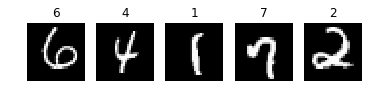

In [4]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

num_samples = 5
indices = random.sample(range(x_test.shape[0] - 1), num_samples)
images, labels = x_test[indices]/255, y_test[indices]

for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
    
prediction = predictor.predict(images.reshape(num_samples, 1, 28, 28))['predictions']
prediction = np.array(prediction)
predicted_label = prediction.argmax(axis=1)
print('The predicted labels are: {}'.format(predicted_label))